In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
import os

### Data
BLAST search run times (preliminary stage plus traceback), in miliseconds, were collected when running 2546 blastp and 6490 blastn queries. The searches were run on two-node, 64-CPU clusters, one search at a time.

In [2]:
directory = 'data/nr-50.tab'
chunk_time = pd.read_csv(directory + '/' + 'nr-50.tab', sep = '\t', index_col = 0)
num_requests = chunk_time.shape[1]
num_db_chunks = chunk_time.shape[0]
print('Number of requests: {}'.format(num_requests))
print('Number of dartabase chunks: {}'.format(num_db_chunks))
chunk_time.head()

Number of requests: 2546
Number of dartabase chunks: 1086


,AFFXMH8C014,AHGSW978014,AFKU0ENV014,AFPCHEH6014,AFFT6EVE014,AFJCB728014,AFNYHXWD014,AFMSAF28014,AFK9ZB6K014,AFJ92Z5S014,...,AFNPAK55014,AFPD5UY1014,AFSHC20Y014,AFGV38G1014,AFF5H6AA014,AFNAP80T014,AFFF7KPH014,AFRUN0PJ014,AFGV5CZM014,AFT4KU11014
nr_50M.179,5854,3527,1086,400,809,1412,425,1862,644,975,...,440,2925,922,1374,508,417,2239,2678,1199,450
nr_50M.176,5473,3153,961,528,708,1510,430,2019,667,956,...,446,3000,830,1745,511,408,2239,2581,1673,575
nr_50M.175,6308,3482,876,532,600,1302,259,2479,673,953,...,481,3229,947,1845,531,417,2165,2751,1549,537
nr_50M.178,5144,3225,865,495,725,1533,391,2222,611,927,...,722,3223,1019,1835,503,519,2218,2627,1730,748
nr_50M.177,6019,2917,1031,440,773,1387,251,2465,626,935,...,699,3236,994,1813,502,663,2340,2571,1612,717


### Data cleaning
There are a few searches that take much longer than others across all chunks. We are removing them to make the search times across RIDs more uniform.

0.9662215239591516 of requests have 75-th percentile below 5000
New number of requests: 2460


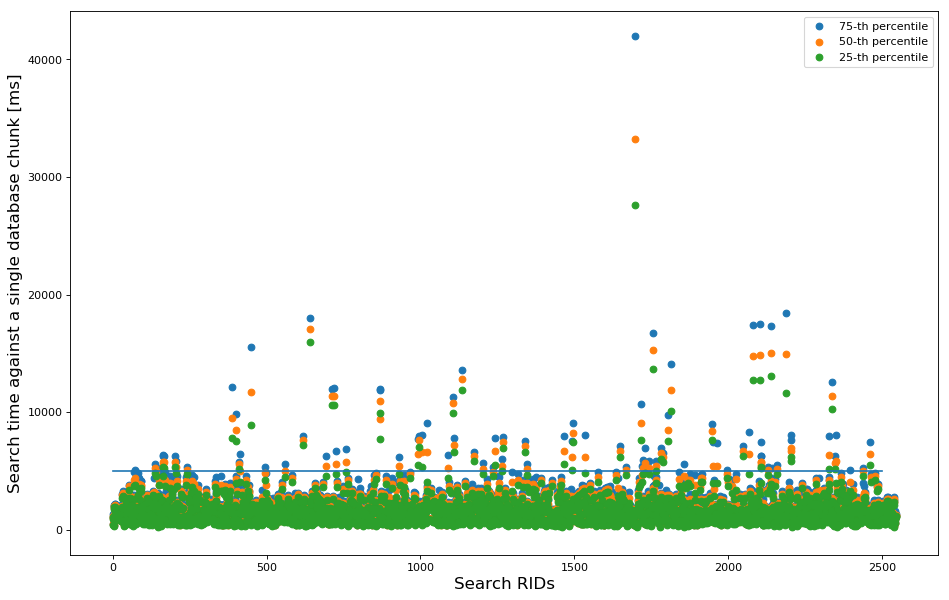

In [11]:
p25 = {}
p50 = {}
p75 = {}
for col in chunk_time:
    sorted_col = chunk_time[col].sort_values()
    p25[col] = sorted_col.iloc[int(num_db_chunks * 0.25)]
    p50[col] = sorted_col.iloc[int(num_db_chunks * 0.5)]
    p75[col] = sorted_col.iloc[int(num_db_chunks * 0.75)]

m = pd.DataFrame({'p25': p25, 'p50': p50, 'p75': p75})
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(range(0, num_requests), m['p75'])
plt.scatter(range(0, num_requests), m['p50'])
plt.scatter(range(0, num_requests), m['p25'])

plt.xlabel('Search RIDs', fontsize = 15)
plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)
plt.legend(['75-th percentile', '50-th percentile', '25-th percentile'])

p75_limit = 5000
plt.plot([0, 2500], [p75_limit, p75_limit])

print('{} of requests have 75-th percentile below {}'.format((m['p75'] < p75_limit).sum() / num_requests, p75_limit))
ch = pd.DataFrame()
for rid in chunk_time:
    if p75[rid] < p75_limit:
        ch[rid] = chunk_time[rid]

chunk_time = ch
num_requests = chunk_time.shape[1]
print('New number of requests: {}'.format(num_requests))

### Hot spots
We find hot spots as outlier data points that are larger than 1.5 times the interquarile distance from the 75-th percentile (the same way as shown in the box-and-wiskers plot). Then for each database chunk we count in how many searches it was a hot spot.

In [12]:
outliers = None
for rid in chunk_time:
    t = chunk_time[rid]
    q = t.quantile(q = [0.25, 0.75], interpolation = 'nearest')
    # everything above this value is shown as an outlier in a box plot
    wisker = q[0.75] + 1.5 * (q[0.75] - q[0.25])
    
    if outliers is None:
        outliers = pd.DataFrame({rid: t - wisker})
    else:
        outliers[rid] = t - wisker
        
#find and count outliers/hotspots
hotspots = (outliers > 0).sum(axis = 1).sort_values(ascending = False)
print('Number of RIDs for which a database chunk was a hot spot, top 20:')
for index, value in islice(hotspots.iteritems(), 20):
    print('{}\t{}\t{:.2f}'.format(index, value, value / num_requests))

Number of RIDs for which a database chunk was a hot spot, top 20:
nr_50M.199	487	0.20
nr_50M.165	436	0.18
nr_50M.268	352	0.14
nr_50M.610	351	0.14
nr_50M.609	338	0.14
nr_50M.753	334	0.14
nr_50M.267	330	0.13
nr_50M.1059	285	0.12
nr_50M.421	282	0.11
nr_50M.858	280	0.11
nr_50M.198	265	0.11
nr_50M.510	244	0.10
nr_50M.859	241	0.10
nr_50M.463	230	0.09
nr_50M.950	227	0.09
nr_50M.611	212	0.09
nr_50M.637	209	0.08
nr_50M.180	202	0.08
nr_50M.285	192	0.08
nr_50M.613	181	0.07


For nr_50M hotspots strongly depend an a query.

In [14]:
hotspots.quantile(q = [0, 0.25, 0.5, 0.5, 0.75, 0.95, 1], interpolation = 'nearest')

0.00      0
0.25      1
0.50      8
0.50      8
0.75     25
0.95     85
1.00    487
dtype: int64

In [6]:
hotspots.idxmax()


'nr_50M.199'

#### Worst offenders
The figure below shows run times for top five database chunks that are hot spots for the largest number of queries. Most queries yield a small and consistent run time. These chunks are hot spots for only a few queries.

Text(0, 0.5, 'Search time against a single database chunk [ms]')

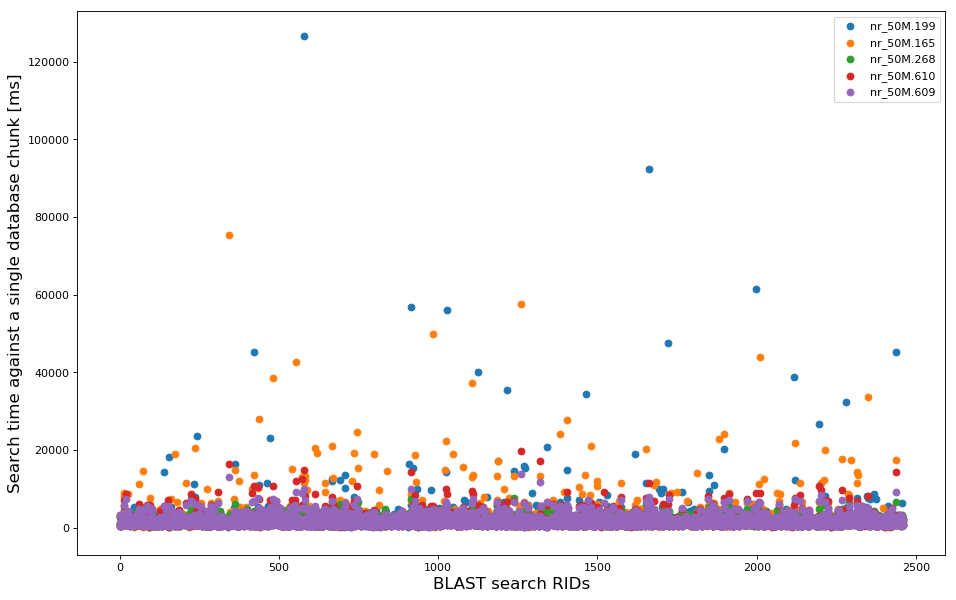

In [15]:
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
for index, value in islice(hotspots.iteritems(), 5):
    plt.scatter(range(0, chunk_time.shape[1]), chunk_time.loc[index])
plt.legend(hotspots.index[:5])
plt.xlabel('BLAST search RIDs', fontsize = 15)
plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)

### Best behaving chunks
Below we show run times for the 5 best behaving chunks: these that are hotspots for the fewest number of RIDs. There are no hotspots. Run times are consistent.

Text(0, 0.5, 'Search time against a single database chunk [ms]')

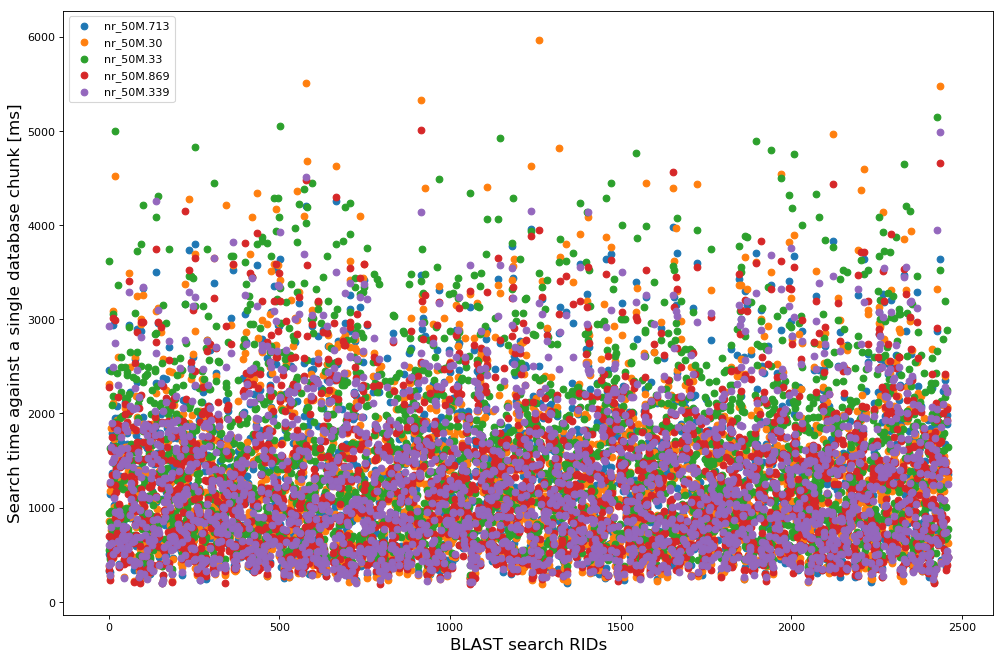

In [16]:
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for index, value in islice(hotspots.iteritems(), hotspots.shape[0] - 5, None):
    plt.scatter(range(0, chunk_time.shape[1]), chunk_time.loc[index])
plt.legend(hotspots.index[-5:])
plt.xlabel('BLAST search RIDs', fontsize = 15)
plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)

### Best and worst behaving queries
Let us now look at search requests with the largest and smallest number of hotspots. Below we show run times for five RIDs that have the largest number of hot spots. Hot sots are clearly visible.

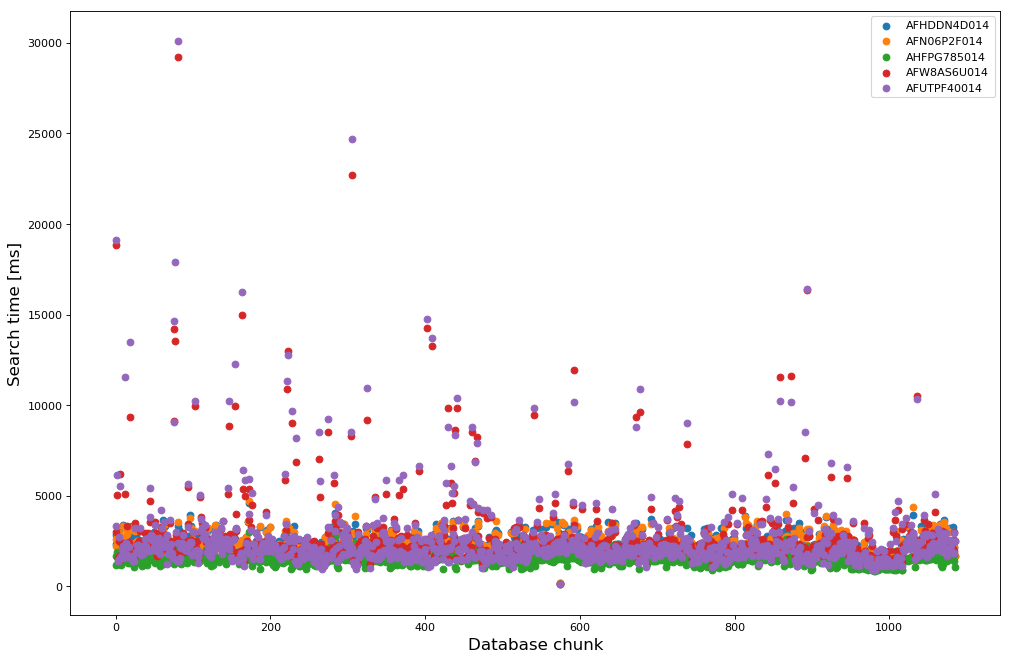

In [17]:
# RIDs with most outliers
h = (outliers > 0).sum(axis = 0).sort_values(ascending = False).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.legend(h)

Below we show five queries with the fewest hotspots. There are no hot spots in the plot.

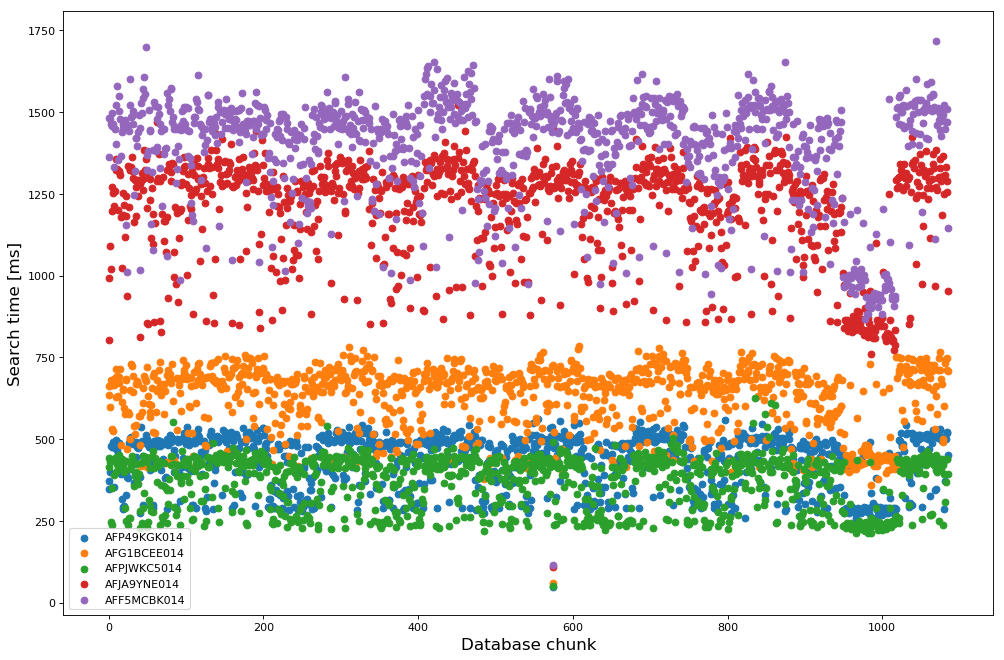

In [18]:
# RIDs with least outliers
h = (outliers > 0).sum(axis = 0).sort_values(ascending = True).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.legend(h)